# eQTL Methods Exploration

I want to look at the effect of using different expression estimates.

In [69]:
import cPickle
import glob
import gzip
import os
import random
import shutil
import subprocess
import sys

import cdpybio as cpb
import matplotlib.pyplot as plt
import mygene
import myvariant
import numpy as np
import pandas as pd
import pybedtools as pbt
import scipy.stats as stats
import seaborn as sns

import ciepy
import cardipspy as cpy

%matplotlib inline
%load_ext rpy2.ipython

dy_name = 'eqtl_methods_exploration'

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', 'tmp', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [56]:
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rnaseq_metadata.tsv')
rna_meta = pd.read_table(fn, index_col=0)

In [27]:
fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 'gene_to_regions.p')
gene_to_regions = cPickle.load(open(fn, 'rb'))
gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)

In [5]:
def orig_dir():
    os.chdir('/raid3/projects/CARDIPS/analysis/cardips-ipsc-eqtl/notebooks/')

I've copied the methods from the `run_emmax.py` script here so I can run some
simple analyses.

This is an example call to `run_emmax.py`:

    python /raid3/projects/CARDIPS/analysis/cardips-ipsc-eqtl/scripts/run_emmax.py \
        ENSG00000103723.8 \
        /raid3/projects/CARDIPS/analysis/cardips-ipsc-eqtl/private_data/wgs/biallelic_snvs.vcf.gz \
        chr15:82331447-84378665 \
        /raid3/projects/CARDIPS/analysis/cardips-ipsc-eqtl/output/eqtl_input/vst_counts_phe.tsv \
        /raid3/projects/CARDIPS/analysis/cardips-ipsc-eqtl/output/eqtl_input/emmax.ind \
        /raid3/projects/CARDIPS/analysis/cardips-ipsc-eqtl/output/eqtl_input/wgs.kin \
        /raid3/projects/CARDIPS/analysis/cardips-ipsc-eqtl/output/run_eqtl_analysis/test_results/ENSG00000103723.8 \
        -c /raid3/projects/CARDIPS/analysis/cardips-ipsc-eqtl/output/eqtl_input/emmax.cov
        
The genes ENSG00000189306.6 and ENSG00000169715.10 are significant while ENSG00000181315.6
and ENSG00000198912.6 are not significant. I can use these for testing.

## Different Expression Estimates

I'm considering using three different expression estimates:
* naive counts: The number of reads overlapping a gene.
* RSEM effective counts: The effective counts estimated by RSEM.
* RSEM TPM: Transcript TPM summed together per gene.

In [7]:
fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'eqtls01', 'qvalues.tsv')
qvalues = pd.read_table(fn, index_col=0)

In [6]:
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rsem_tpm.tsv')
tpm = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rsem_expected_counts_norm.tsv')
ec = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'gene_counts_norm.tsv')
gc = pd.read_table(fn, index_col=0)

Transform to standard normal and change IDs to match those in VCF.

In [74]:
tpm = tpm[rna_meta[rna_meta.in_eqtl].index]
tpm.columns = rna_meta[rna_meta.in_eqtl].wgs_id
tpm_sn = cpb.general.transform_standard_normal(tpm)
tpm_sn.to_csv(os.path.join(outdir, 'tpm_sn.tsv'), sep='\t')

ec = ec[rna_meta[rna_meta.in_eqtl].index]
ec.columns = rna_meta[rna_meta.in_eqtl].wgs_id
ec_sn = cpb.general.transform_standard_normal(ec)
ec_sn.to_csv(os.path.join(outdir, 'ec_sn.tsv'), sep='\t')

gc = gc[rna_meta[rna_meta.in_eqtl].index]
gc.columns = rna_meta[rna_meta.in_eqtl].wgs_id
gc_sn = cpb.general.transform_standard_normal(gc)
gc_sn.to_csv(os.path.join(outdir, 'gc_sn.tsv'), sep='\t')

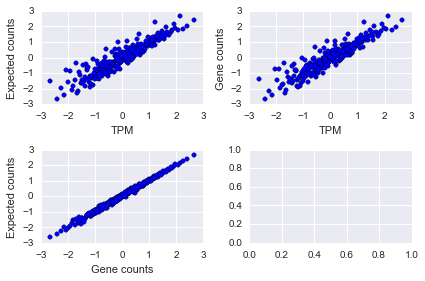

In [26]:
fig,axs = plt.subplots(2, 2)
ax = axs[0, 0]
ax.scatter(tpm_sn.ix[qvalues.index[0]], ec_sn.ix[qvalues.index[0]])
ax.set_ylabel('Expected counts')
ax.set_xlabel('TPM')
ax = axs[0, 1]
ax.scatter(tpm_sn.ix[qvalues.index[0]], gc_sn.ix[qvalues.index[0]])
ax.set_ylabel('Gene counts')
ax.set_xlabel('TPM')
ax = axs[1, 0]
ax.scatter(gc_sn.ix[qvalues.index[0]], ec_sn.ix[qvalues.index[0]])
ax.set_ylabel('Expected counts')
ax.set_xlabel('Gene counts')
plt.tight_layout();

In [85]:
def make_emmax_sh(gene, exp, exp_name):
    out = os.path.join(private_outdir, '{}_{}'.format(gene, exp_name))
    cpy.makedir(out)
    f = open(os.path.join(out, '{}.sh'.format(gene)), 'w')
    f.write('#!/bin/bash\n\n')
    f.write('#$ -N emmax_{}_{}_test\n'.format(gene, exp_name))
    f.write('#$ -l opt\n')
    f.write('#$ -l h_vmem=2G\n')
    f.write('#$ -pe smp 4\n')
    f.write('#$ -S /bin/bash\n')
    f.write('#$ -o {}.out\n'.format(os.path.join(out, gene)))
    f.write('#$ -e {}.err\n\n'.format(os.path.join(out, gene)))

    f.write('module load cardips/1\n')
    f.write('source activate cie\n\n')

    f.write('python /frazer01/projects/CARDIPS/analysis/cardips-ipsc-eqtl/scripts/run_emmax.py \\\n')
    f.write('\t{} \\\n'.format(gene))
    f.write('\t/frazer01/projects/CARDIPS/analysis/cardips-ipsc-eqtl/private_output/eqtl_input/filtered_all/0000.vcf.gz \\\n')
    f.write('\t{} \\\n'.format(gene_to_regions[gene][0][3:]))
    f.write('\t{} \\\n'.format(exp))
    f.write('\t/frazer01/projects/CARDIPS/analysis/cardips-ipsc-eqtl/output/eqtl_input/emmax_samples.tsv \\\n')
    f.write('\t/frazer01/projects/CARDIPS/analysis/cardips-ipsc-eqtl/output/eqtl_input/wgs.kin \\\n')
    f.write('\t{} \\\n'.format(out))
    f.write('\t-c /frazer01/projects/CARDIPS/analysis/cardips-ipsc-eqtl/output/eqtl_input/emmax_full.tsv \\\n')
    f.write('\t-a 0\n')
    f.close()
    return os.path.join(out, '{}.sh'.format(gene))

In [ ]:
genes = qvalues.index[0:5000:500]
names = ['tpm', 'ec', 'gc']
for gene in genes:
    for i,exp in enumerate([os.path.join(outdir, 'tpm_sn.tsv'), 
                            os.path.join(outdir, 'ec_sn.tsv'), 
                            os.path.join(outdir, 'gc_sn.tsv')]):
        exp_name = names[i]
        fn = make_emmax_sh(gene, exp, exp_name)
        !qsub {fn}

In [103]:
def plot_results(gene):
    gene = genes[0]
    fn = os.path.join(private_outdir, '{}_tpm'.format(gene), gene + '.tsv')
    tpm_res = ciepy.read_emmax_output(fn).dropna()
    fn = os.path.join(private_outdir, '{}_ec'.format(gene), gene + '.tsv')
    ec_res = ciepy.read_emmax_output(fn).dropna()
    fn = os.path.join(private_outdir, '{}_gc'.format(gene), gene + '.tsv')
    gc_res = ciepy.read_emmax_output(fn).dropna()
    for c in ['BETA', 'R2']:
        df = pd.DataFrame({'tpm': tpm_res[c], 'ec': ec_res[c], 'gc': gc_res[c]})
        sns.pairplot(df)
        plt.title(c)
    df = pd.DataFrame({'tpm': -np.log10(tpm_res['PVALUE']), 
                       'ec': -np.log10(ec_res['PVALUE']), 
                       'gc': -np.log10(gc_res['PVALUE'])})
    sns.pairplot(df)
    plt.title('$-\log_{10}$ $p$ value');

/frazer01/home/cdeboever/software/anaconda/envs/cie/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


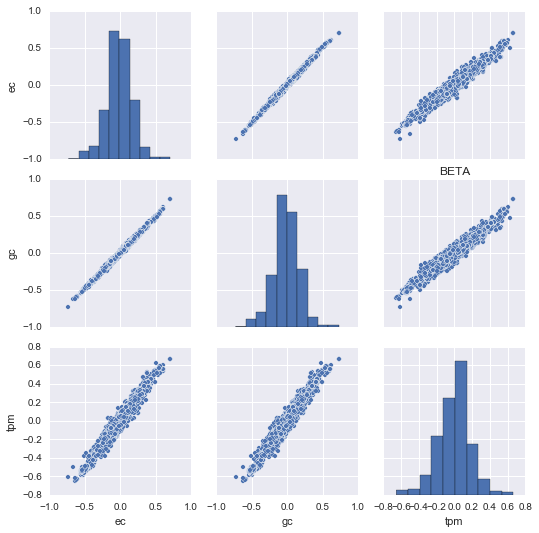

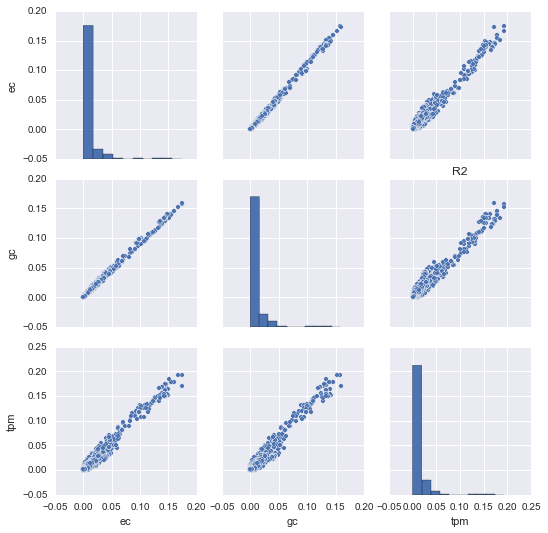

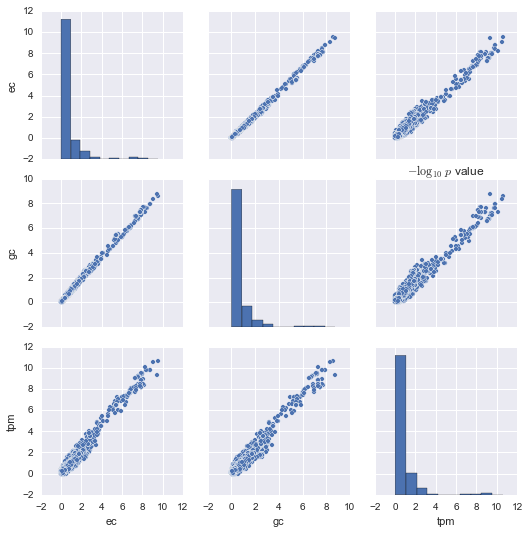

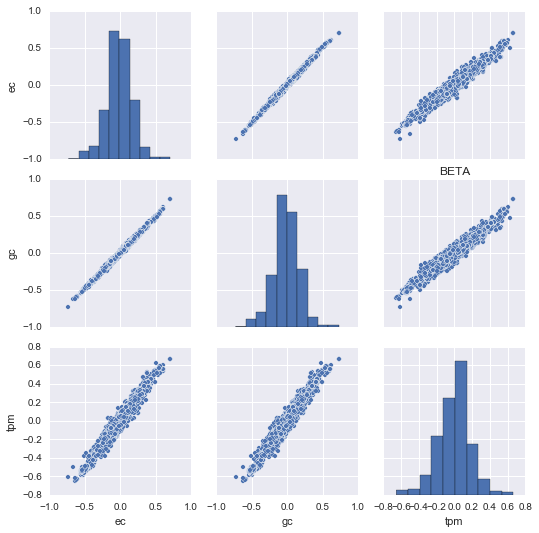

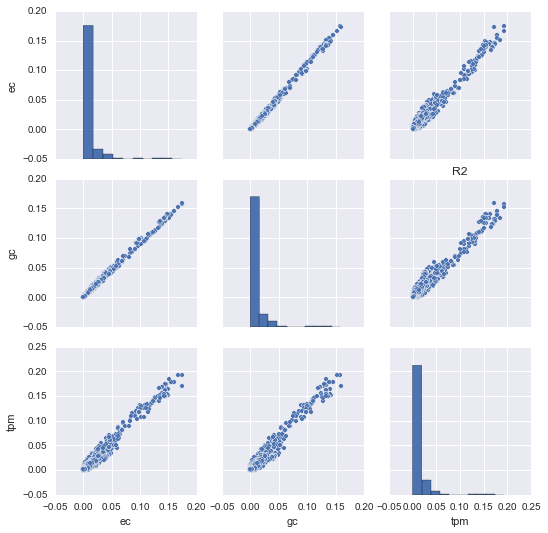

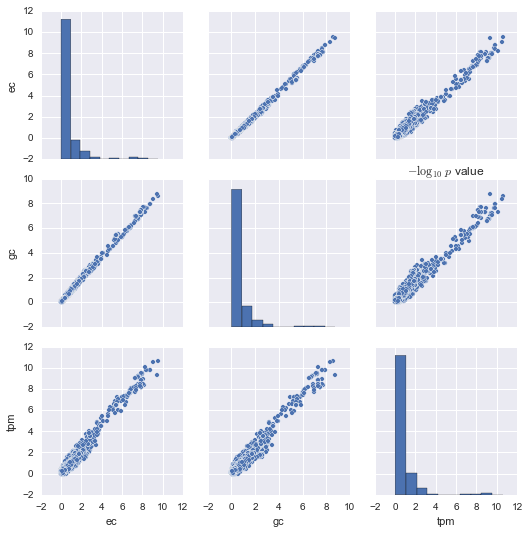

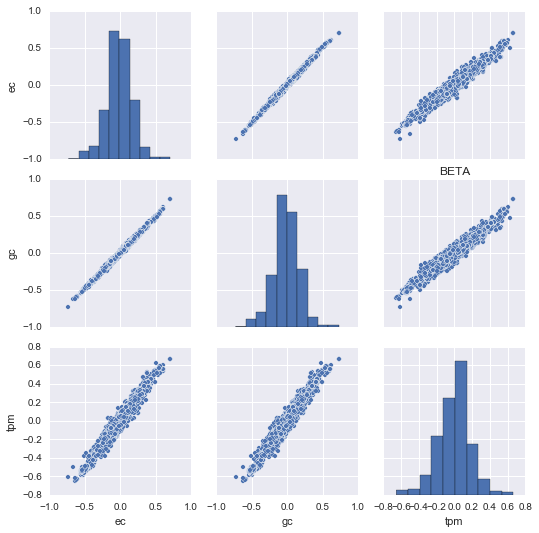

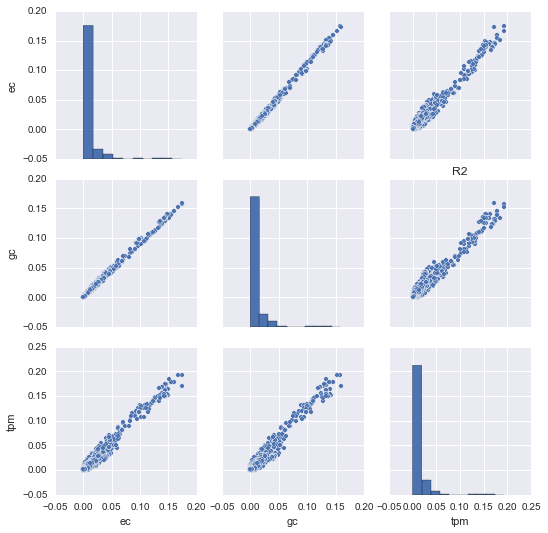

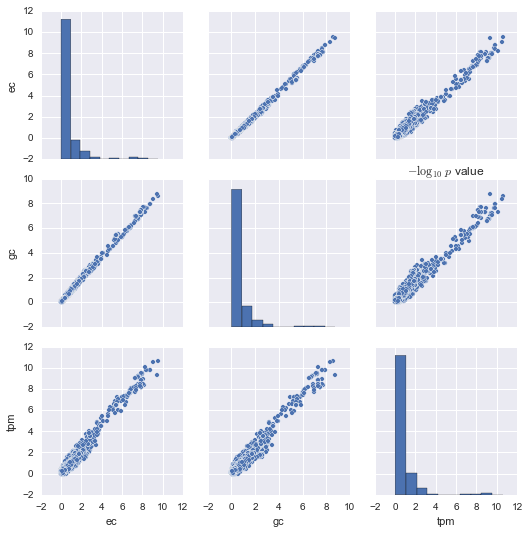

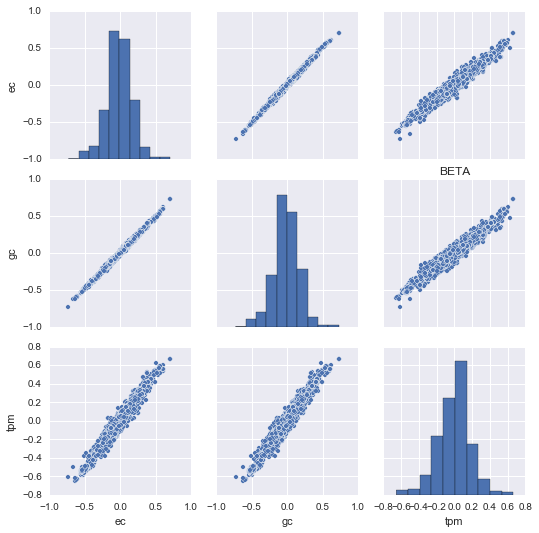

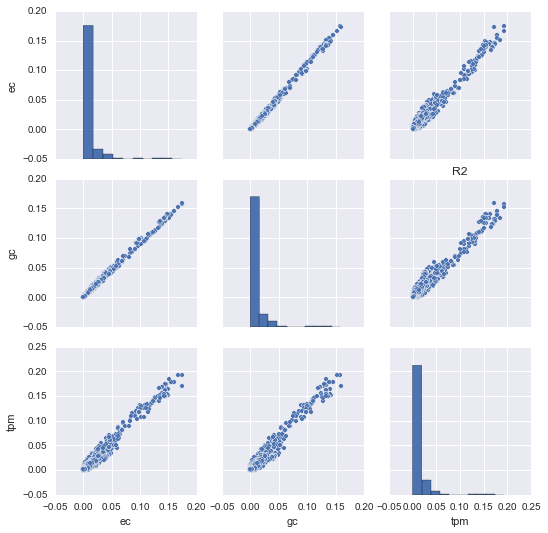

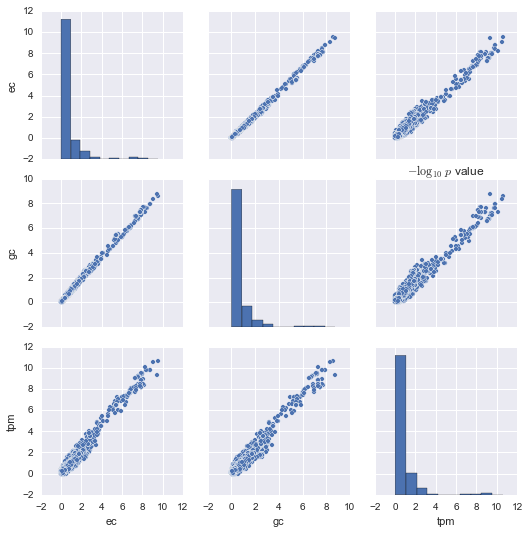

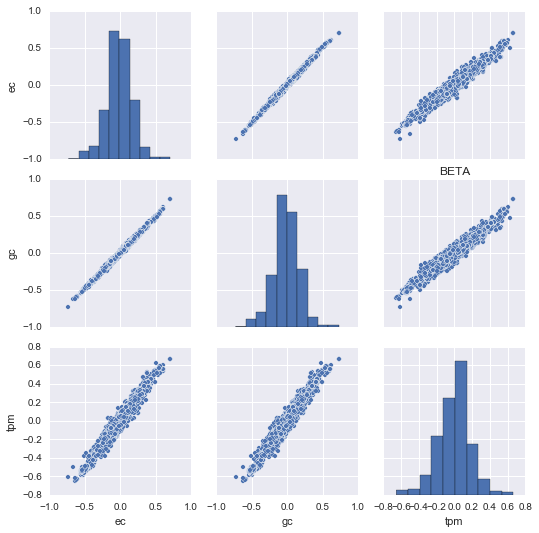

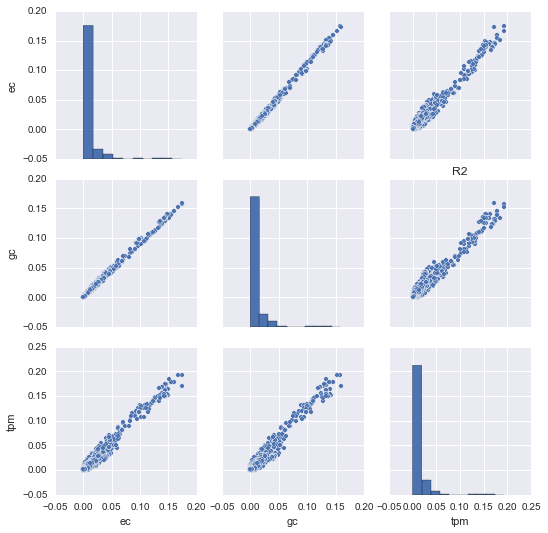

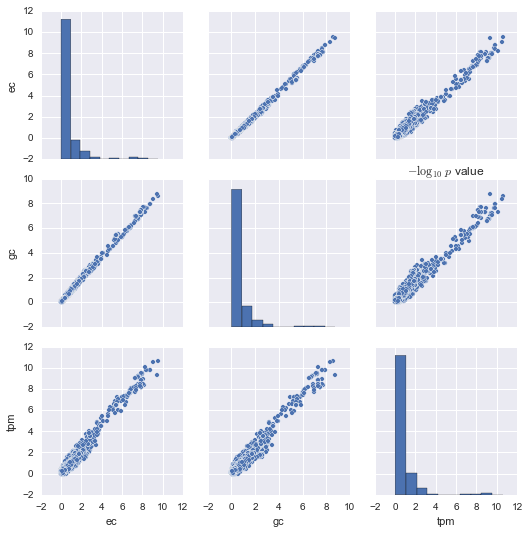

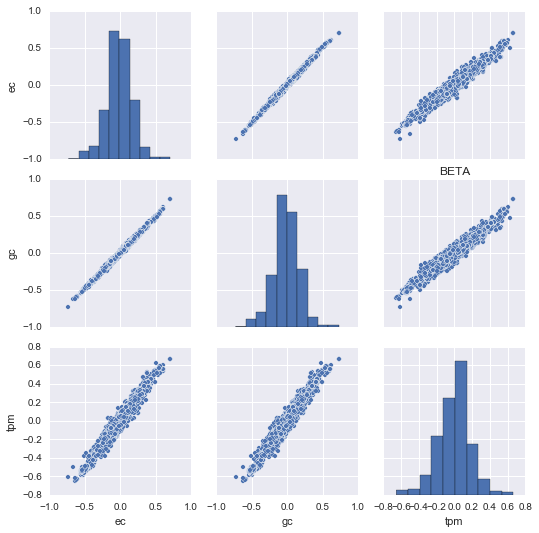

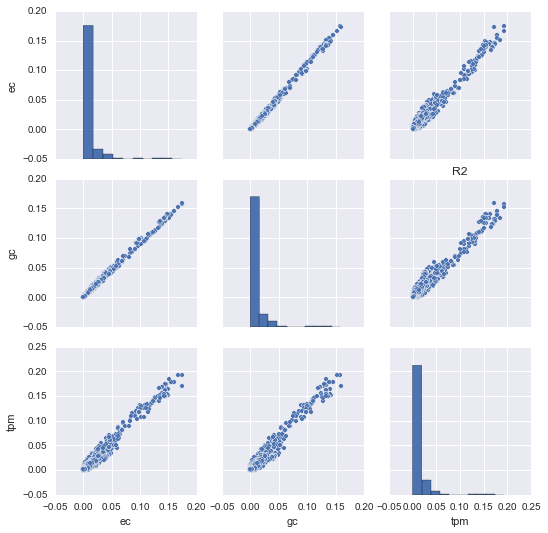

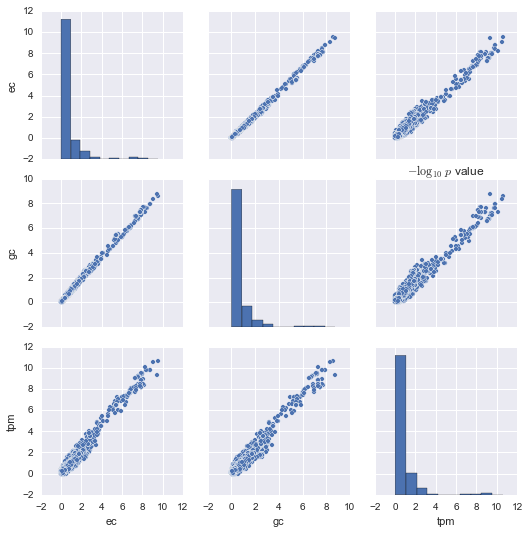

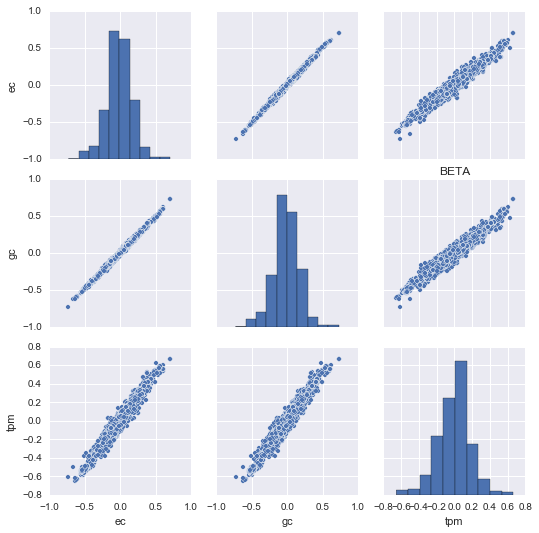

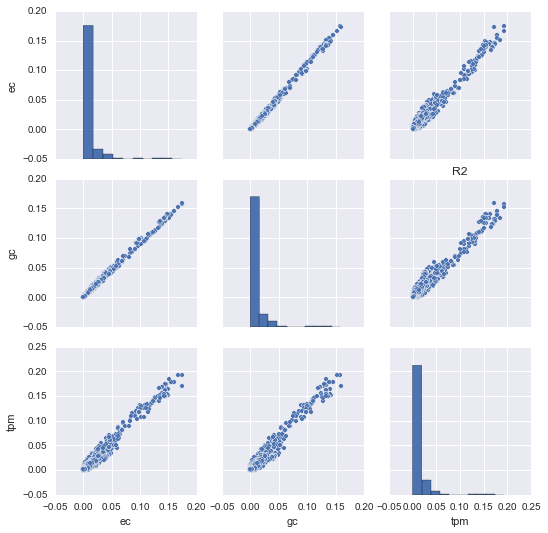

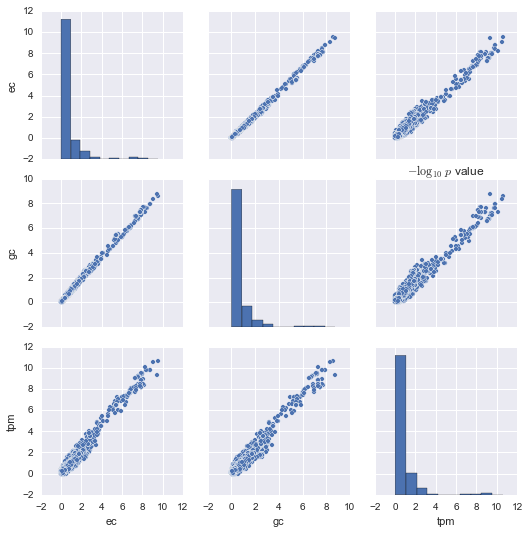

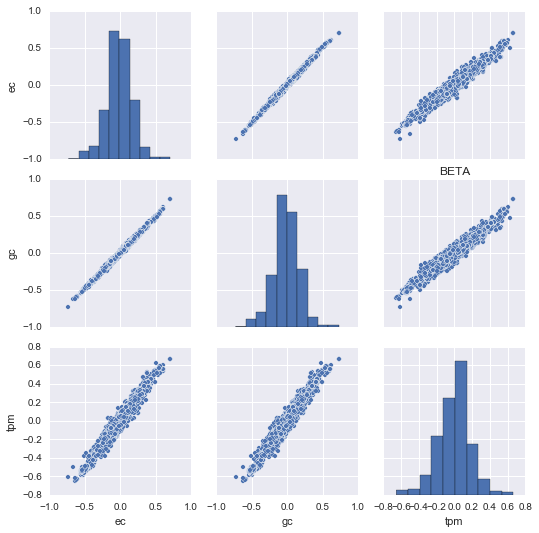

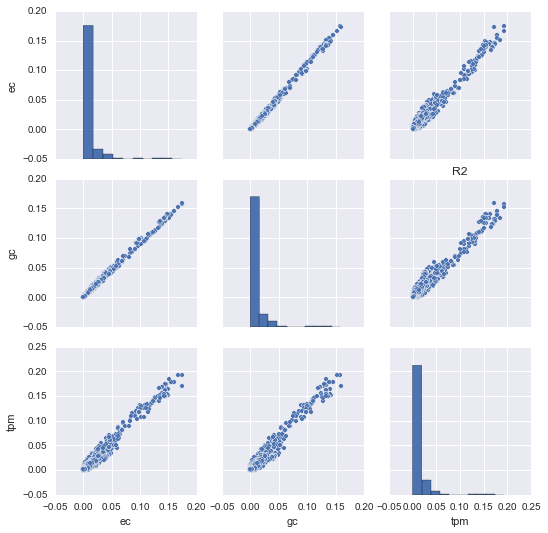

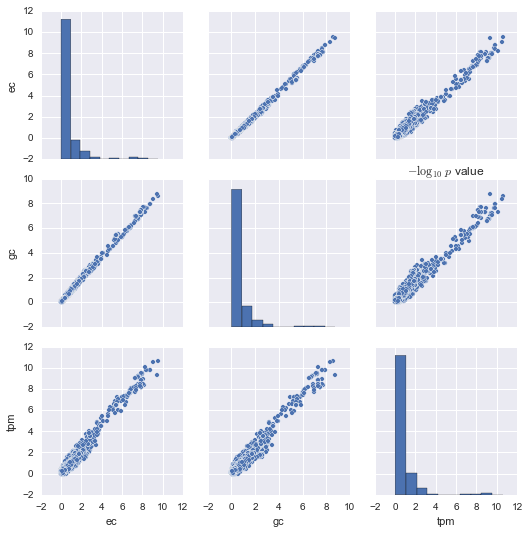

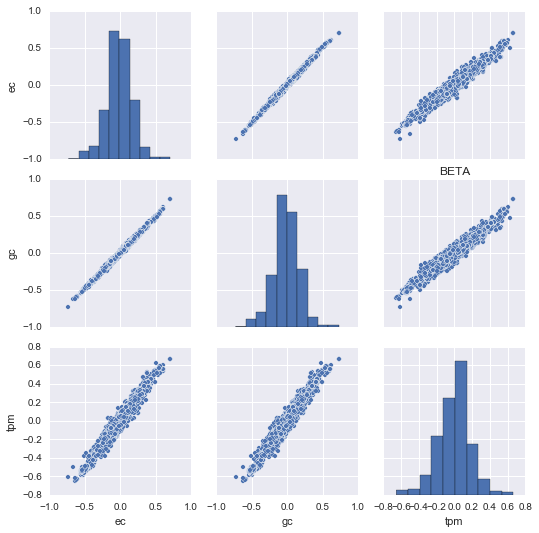

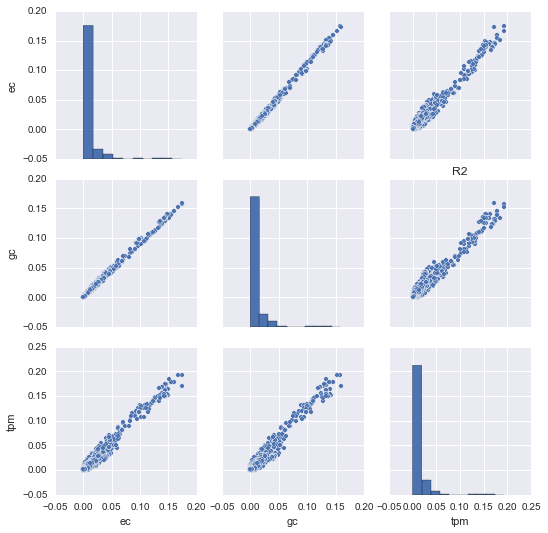

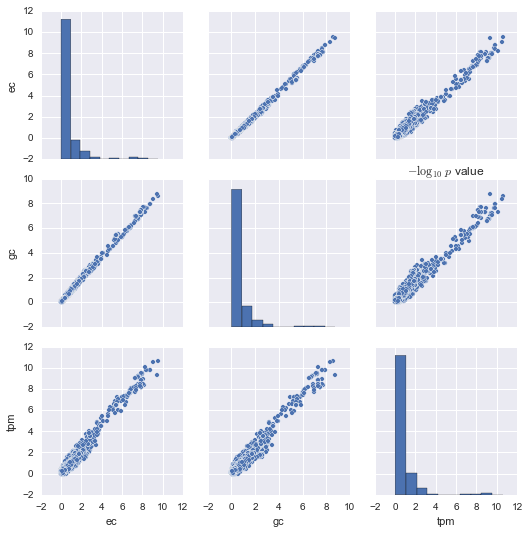

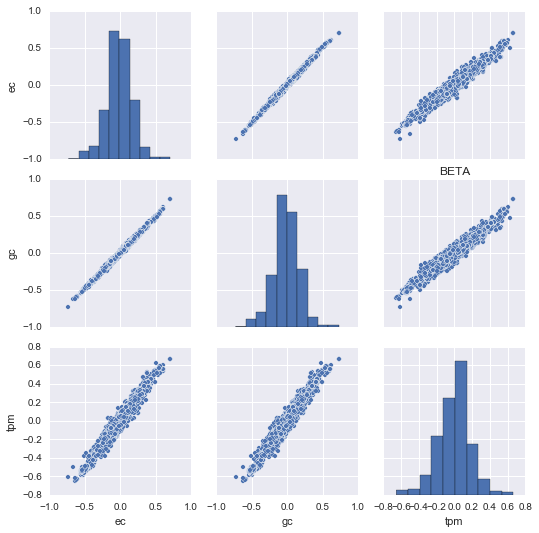

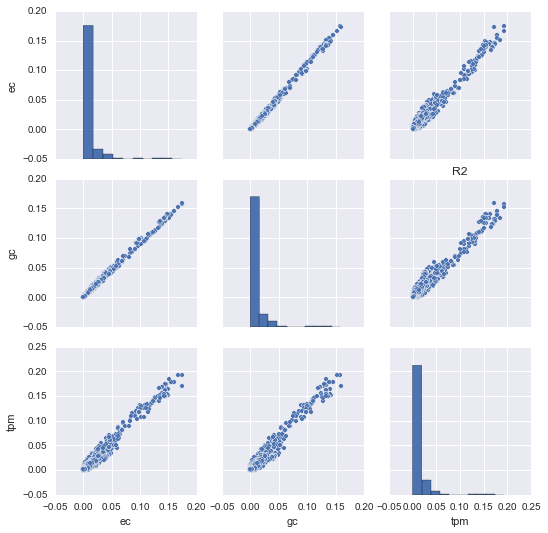

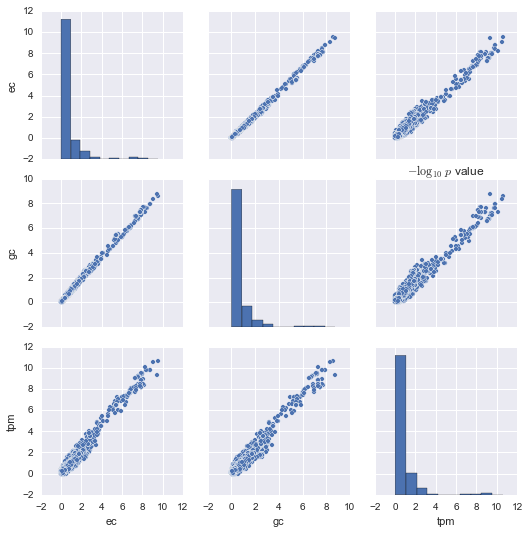

In [104]:
for g in genes:
    plot_results(g)

We can see that expected counts and naive counts are very similar. TPM seems to have
larger $R^2$ and $\beta$ values.